# Digit-Recognizer

In [35]:
#Import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import keras
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization

import cv2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input as preprocess_input_vgg

In [5]:
#Load the datasets - training as well as test
train = pd.read_csv("train.csv", header=0, sep=",")
test =  pd.read_csv("test.csv", header=0, sep=",")

# Data Preprocessing

In [6]:
#check the dimentions of the datsets
print(train.shape)
print(test.shape)

(42000, 785)
(28000, 784)


In [7]:
#Categorize the label column and check whether we have a balanced dataset.
train_labels = pd.Categorical(train.loc[:,"label"])
train_labels.value_counts()

0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
dtype: int64

In [8]:
#convert datasets into numpy arrays
train_df = np.array(train.drop("label",axis=1))
test_df = np.array(test)

In [19]:
# train-test split of data
num_classes = 10
img_size = 28

x_train, x_test, y_train, y_test = train_test_split(train_df,train.loc[:,"label"],test_size=0.20,random_state=0)

print("x_train.shape :",x_train.shape)
print("x_test.shape :",x_test.shape)
print("y_train.shape :",y_train.shape)
print("y_test.shape :",y_test.shape)

x_train.shape : (33600, 784)
x_test.shape : (8400, 784)
y_train.shape : (33600,)
y_test.shape : (8400,)


In [20]:
#Image augmentation
from scipy.ndimage.interpolation import shift

def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])
X_train_augmented = [image for image in x_train]
Y_train_augmented = [image for image in y_train]
for dx, dy in ((1,0), (-1,0), (0,1), (0,-1)):
     for image, label in zip(x_train, y_train):
             X_train_augmented.append(shift_image(image, dx, dy))
             Y_train_augmented.append(label)
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = np.array(X_train_augmented)[shuffle_idx]
Y_train_augmented = np.array(Y_train_augmented)[shuffle_idx]

#Scaling training and testing datasets
from sklearn.preprocessing import MinMaxScaler
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train_augmented)
X_train_augmented_rescaled = scaling.transform(X_train_augmented)
X_test_augmented_rescaled = scaling.transform(x_test)

In [21]:
#check for dataset dimentions again
print("X_train_augmented.shape :",X_train_augmented.shape)
print("Y_train_augmented.shape :",Y_train_augmented.shape)

X_train_augmented.shape : (168000, 784)
Y_train_augmented.shape : (168000,)


In [22]:
X_train_augmented_rescaled_reshaped = X_train_augmented.reshape(X_train_augmented_rescaled.shape[0],img_size,img_size,1)
X_test_augmented_rescaled_reshaped = x_test.reshape(X_test_augmented_rescaled.shape[0],img_size,img_size,1)

#one-hot-encoding of categorical data - 10 categories
Y_train_augmented_reshaped = keras.utils.to_categorical(Y_train_augmented, num_classes)
Y_test_augmented_reshaped = keras.utils.to_categorical(y_test, num_classes)

print("X_train_augmented_rescaled_reshaped.shape :",X_train_augmented_rescaled_reshaped.shape)
print("X_test_augmented_rescaled_reshaped.shape :",X_test_augmented_rescaled_reshaped.shape)
print("Y_train_augmented_reshaped.shape :",Y_train_augmented_reshaped.shape)
print("Y_test_augmented_reshaped.shape :",Y_test_augmented_reshaped.shape)

X_train_augmented_rescaled_reshaped.shape : (168000, 28, 28, 1)
X_test_augmented_rescaled_reshaped.shape : (8400, 28, 28, 1)
Y_train_augmented_reshaped.shape : (168000, 10)
Y_test_augmented_reshaped.shape : (8400, 10)


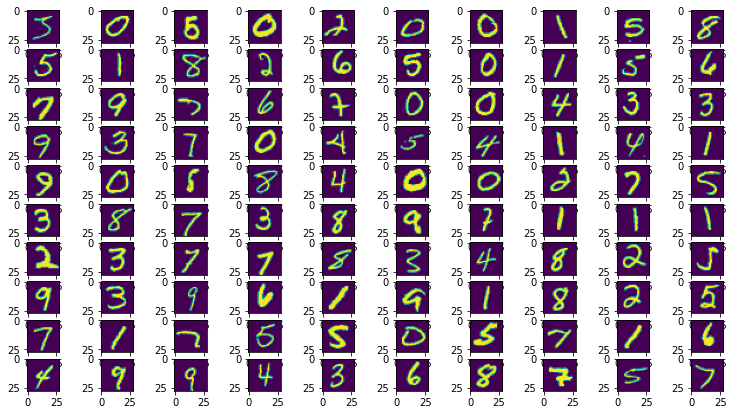

In [23]:
#Lets view first 100 images in dataset
plt.figure(figsize=(13,7))
for i in range(1, 101):
    plt.subplot(10, 10, i)
    plt.imshow(X_train_augmented_rescaled_reshaped[i][:,:,0])

In [25]:
#More Image augmentation
datagen = ImageDataGenerator(featurewise_center=False,
                             samplewise_center=False,
                             featurewise_std_normalization=False,
                             samplewise_std_normalization=False,
                             zca_whitening=False,
                             rotation_range=10.,       # randomly rotate images in the range (degrees, 0 to 180)
                             zoom_range = 0.1,
                             shear_range=0.1,
                             width_shift_range=0.1,    # randomly shift images horizontally (fraction of total width)
                             height_shift_range=0.1,   # randomly shift images vertically (fraction of total height)
                             channel_shift_range=0.1,  # set range for random channel shifts
                             fill_mode='constant',     # set mode for filling points outside the input boundaries
                             horizontal_flip=False,    # randomly flip images
                             vertical_flip=False
                            )
datagen.fit(X_train_augmented_rescaled_reshaped)

# CNN MODEL

In [26]:
# much more conv2d layer and maxpooling layer could be added but would may also reduce the accuracy
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.05))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.15))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(10, activation = "softmax"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)         

In [27]:
#Set hyperparameters for the model
epochs = 10
batch_size = 1680
optimizer = tensorflow.keras.optimizers.RMSprop(lr=0.001)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [28]:
# Fit the model
history = model.fit(datagen.flow(X_train_augmented_rescaled_reshaped,Y_train_augmented_reshaped, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_test_augmented_rescaled_reshaped,Y_test_augmented_reshaped),
                              verbose = 1, steps_per_epoch=X_train_augmented_rescaled_reshaped.shape[0] // batch_size)

Epoch 1/10
100/100 [==============================] - 873s 9s/step - loss: 1.6769 - accuracy: 0.6389 - val_loss: 0.0696 - val_accuracy: 0.9787
Epoch 2/10
100/100 [==============================] - 879s 9s/step - loss: 0.2978 - accuracy: 0.9196 - val_loss: 0.0449 - val_accuracy: 0.9860
Epoch 3/10
100/100 [==============================] - 1129s 11s/step - loss: 0.1145 - accuracy: 0.9661 - val_loss: 0.0368 - val_accuracy: 0.9893
Epoch 4/10
100/100 [==============================] - 862s 9s/step - loss: 0.0893 - accuracy: 0.9736 - val_loss: 0.0270 - val_accuracy: 0.9923
Epoch 5/10
100/100 [==============================] - 1028s 10s/step - loss: 0.0715 - accuracy: 0.9791 - val_loss: 0.0267 - val_accuracy: 0.9918
Epoch 6/10
100/100 [==============================] - 1059s 11s/step - loss: 0.0618 - accuracy: 0.9818 - val_loss: 0.0587 - val_accuracy: 0.9844
Epoch 7/10
100/100 [==============================] - 1419s 14s/step - loss: 0.0554 - accuracy: 0.9838 - val_loss: 0.0216 - val_accuracy

In [29]:
#Compute loss and accuracy for our model on validation data
loss, acc = model.evaluate(X_test_augmented_rescaled_reshaped,Y_test_augmented_reshaped)
print("loss :",loss)
print("accuracy :",acc)

263/263 [==============================] - 12s 46ms/step - loss: 0.0212 - accuracy: 0.9943
loss : 0.021198827773332596
accuracy : 0.9942857027053833


In [30]:
#save model for future reference
model.save('/Users/dabasn/Desktop/Nitesh/Kaggle/digit-recognizer/')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /Users/dabasn/Desktop/Nitesh/Studies/Kaggle/digit-recognizer/assets


In [31]:
#reshape test data for prediction
test_df = test_df.reshape(test.shape[0],img_size,img_size,1)

In [32]:
#Predict model output on test data
predict = model.predict(test_df)
predict = np.argmax(predict,axis = 1)
print(predict)

[2 0 9 ... 3 9 2]


In [33]:
#set the output to submission.csv file
sId = pd.read_csv("sample_submission.csv")
ids = sId.drop("Label",axis=1)
output = pd.DataFrame({ 'ImageId' : sId.ImageId, 'Label': predict})
output.to_csv('submission.csv', index=False)